In [10]:

from typing import List

import spconv
import sphconv
import torch
from sphconv.datagen import VoxelizationVFE, merge_batch_torch
from sphconv.utils import out_spatial


def batch_real_test_inputs(
    channel: int,
    batch_size: int,
    spatial_shape_DWH: List[int]
):
    TEST_FILE_MAX = 4
    vvfe = VoxelizationVFE(resolution_HWD=spatial_shape_DWH[::-1])

    example_list = []
    for i in range(batch_size):
        voxels, coords = vvfe.generate(
            '{:06d}.bin'.format(i %  TEST_FILE_MAX),  torch.device('cuda:0'))
        example_list.append({'voxels': voxels, 'coordinates': coords})
    example = merge_batch_torch(example_list)

    feature, indices = example['voxels'], example['coordinates']
    # feature, [NNZ, 4]
    # original channel is 4, we extend it if needed
    assert channel >= 4;
    if channel > 4:
        feature = feature.repeat((1, (channel + 3) //4))
        feature = feature[:, :channel]
    return feature, indices


def batch_artifical_inputs(
    indices_zyx: torch.Tensor,
    channel: int,
    batch_size: int
):
    """
    create batched inputs from indices_zyx
    """
    features = torch.randn(
        (indices_zyx.shape[0], channel), dtype=torch.float, device=indices_zyx.device)

    one_example = {'voxel': features, 'coordinates': indices_zyx}
    example = merge_batch_torch([one_example] * batch_size)

    return example['voxel'], example['coordinates']


def assert_correct_cmp_with_spconv(
    indices_zyx: torch.Tensor, # [NNZ, 3]
    batch_size: int,
    in_channels: int, out_channels: int,
    spatial_shape_DWH: List[int],
    kernel_size: List[int],
    stride: List[int],
    padding: List[int],
    dilation: List[int] = [1, 1, 1],
    subm: bool = False
):
    if subm:
        assert dilation == stride == dilation == [1, 1, 1]

    feature, indices = batch_artifical_inputs(
        indices_zyx, channel=in_channels, batch_size=batch_size)

    sphconv_tensor = sphconv.SparseConvTensor(
        feature, spatial_shape_DWH, batch_size, indices=indices)

    spconv_tensor = spconv.SparseConvTensor(
        feature, indices, spatial_shape_DWH, batch_size)

    sph_conv = sphconv.Conv3d(
        in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False, subm=subm).cuda()

    Spconv_Conv3d = spconv.SubMConv3d if subm else spconv.SparseConv3d
    sp_conv = Spconv_Conv3d(
        in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False).cuda()

    # same weight
    weight = torch.randn((*kernel_size, in_channels, out_channels),
                         dtype=torch.float, device=indices.device)

    sph_conv.weight = torch.nn.Parameter(weight.clone())
    sp_conv.weight = torch.nn.Parameter(weight.clone())

    with torch.no_grad():
        spconv_dense = sp_conv(spconv_tensor).dense()
        sphconv_dense = sph_conv(sphconv_tensor).dense()

    print("sphconv = ", sphconv_dense)
    print("spconv = ", spconv_dense)

    assert torch.isclose(spconv_dense, sphconv_dense, rtol=0.01).all()



def assert_correct_cmp_with_spconv_real(
    batch_size: int,
    in_channels: int, out_channels: int,
    spatial_shape_DWH: List[int],
    kernel_size: List[int],
    stride: List[int],
    padding: List[int],
    dilation: List[int] = [1, 1, 1],
    subm: bool = False
):
    batch_size = 1 # TODO
    if subm:
        assert dilation == stride == dilation == [1, 1, 1]

    feature, indices = batch_real_test_inputs(
        channel=in_channels, batch_size=batch_size, spatial_shape_DWH=spatial_shape_DWH)

    sphconv_tensor = sphconv.SparseConvTensor(
        feature, spatial_shape_DWH, batch_size, indices=indices)

    spconv_tensor = spconv.SparseConvTensor(
        feature, indices, spatial_shape_DWH, batch_size)

    sph_conv = sphconv.Conv3d(
        in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False, subm=subm).cuda()

    Spconv_Conv3d = spconv.SubMConv3d if subm else spconv.SparseConv3d
    sp_conv = Spconv_Conv3d(
        in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False).cuda()

    # same weight
    weight = torch.randn((*kernel_size, in_channels, out_channels),
                         dtype=torch.float, device=indices.device)

    sph_conv.weight = torch.nn.Parameter(weight.clone())
    sp_conv.weight = torch.nn.Parameter(weight.clone())

    with torch.no_grad():
        spconv_dense = sp_conv(spconv_tensor).dense()
        sphconv_dense = sph_conv(sphconv_tensor).dense()

    print("sphconv = ", sphconv_dense)
    print("spconv = ", spconv_dense)

    assert torch.isclose(spconv_dense, sphconv_dense, rtol=0.01).all()


class TestClass:
    def test_conv3D_1(self):

        indices = torch.tensor([
            [0, 0, 0],
            [0, 0, 1],
            [0, 1, 0],
            [1, 1, 1],
        ], dtype=torch.int).cuda()

        assert_correct_cmp_with_spconv(
            indices, batch_size=1, in_channels=16, out_channels=32, spatial_shape_DWH=[2, 2, 2],
            kernel_size=[2, 2, 2], stride=[1, 1, 1], padding=[1, 1, 1], subm=True)
        assert_correct_cmp_with_spconv(
            indices, batch_size=1, in_channels=16, out_channels=32, spatial_shape_DWH=[3, 3, 3],
            kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[1, 1, 1], subm=True)
        assert_correct_cmp_with_spconv(
            indices, batch_size=3, in_channels=16, out_channels=32, spatial_shape_DWH=[2, 2, 8],
            kernel_size=[2, 2, 2], stride=[1, 1, 1], padding=[1, 1, 1], subm=True)

    def test_conv3D_2(self):

        indices = torch.tensor([
            [0, 0, 0],
            [0, 0, 1],
            [0, 1, 0],
            [1, 1, 1],
        ], dtype=torch.int).cuda()

        assert_correct_cmp_with_spconv(
            indices, batch_size=1, in_channels=16, out_channels=32, spatial_shape_DWH=[2, 2, 2],
            kernel_size=[2, 2, 2], stride=[1, 1, 1], padding=[1, 1, 1], subm=False)
        assert_correct_cmp_with_spconv(
            indices, batch_size=1, in_channels=16, out_channels=32, spatial_shape_DWH=[3, 3, 3],
            kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[1, 1, 1], subm=False)
        assert_correct_cmp_with_spconv(
            indices, batch_size=3, in_channels=16, out_channels=32, spatial_shape_DWH=[2, 2, 8],
            kernel_size=[2, 2, 2], stride=[2, 1, 1], padding=[0, 1, 1], subm=False)
        assert_correct_cmp_with_spconv(
            indices, batch_size=3, in_channels=16, out_channels=32, spatial_shape_DWH=[4, 8, 8],
            kernel_size=[3, 3, 3], stride=[1, 1, 2], padding=[1, 1, 0], subm=False)
        assert_correct_cmp_with_spconv(
            indices, batch_size=3, in_channels=16, out_channels=32, spatial_shape_DWH=[20, 20, 20],
            kernel_size=[3, 3, 3], stride=[1, 1, 2], padding=[1, 1, 0], subm=False)


    def test_conv3D_3(self):

        # assert_correct_cmp_with_spconv_real(
        #     batch_size=1, in_channels=16, out_channels=32, spatial_shape_DWH=[2, 2, 2],
        #     kernel_size=[2, 2, 2], stride=[1, 1, 1], padding=[1, 1, 1], subm=False)
        # assert_correct_cmp_with_spconv_real(
        #     batch_size=1, in_channels=16, out_channels=32, spatial_shape_DWH=[3, 3, 3],
        #     kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[1, 1, 1], subm=False)
        assert_correct_cmp_with_spconv_real(
            batch_size=3, in_channels=16, out_channels=32, spatial_shape_DWH=[2, 2, 8],
            kernel_size=[2, 2, 2], stride=[2, 1, 1], padding=[0, 1, 1], subm=False)
        assert_correct_cmp_with_spconv_real(
            batch_size=3, in_channels=16, out_channels=32, spatial_shape_DWH=[4, 8, 8],
            kernel_size=[3, 3, 3], stride=[1, 1, 2], padding=[1, 1, 0], subm=False)
        # assert_correct_cmp_with_spconv_real(
        #     batch_size=3, in_channels=16, out_channels=32, spatial_shape_DWH=[6, 6, 20],
        #     kernel_size=[3, 3, 3], stride=[2, 2, 2], padding=[1, 1, 0], subm=False)
        # assert_correct_cmp_with_spconv_real(
        #     batch_size=3, in_channels=32, out_channels=64, spatial_shape_DWH=[6, 6, 7],
        #     kernel_size=[3, 3, 3], stride=[2, 2, 2], padding=[1, 1, 0], subm=False)

        # assert_correct_cmp_with_spconv_real(
        #     batch_size=3, in_channels=32, out_channels=64, spatial_shape_DWH=[6, 6, 7],
        #     kernel_size=[3, 3, 3], stride=[2, 2, 2], padding=[1, 1, 0], subm=False)

    def test_conv3D_4(self):
        assert_correct_cmp_with_spconv_real(
            batch_size=3, in_channels=64, out_channels=64, spatial_shape_DWH=[12, 12, 12],
            kernel_size=[3, 3, 3], stride=[2, 2, 2], padding=[1, 1, 0], subm=False)

        assert_correct_cmp_with_spconv_real(
            batch_size=3, in_channels=64, out_channels=64, spatial_shape_DWH=[12, 12, 12],
            kernel_size=[3, 3, 3], stride=[2, 2, 2], padding=[1, 1, 0], subm=False)


    def test_rule_cache(self):
        assert True


In [11]:

batch_size=3
in_channels=64
out_channels=64
spatial_shape_DWH=[64, 512, 512]
kernel_size=[3, 3, 3]
stride=[1, 1, 1]
dilation=[1,1,1]
padding=[1, 1, 1]
subm=True

In [12]:
from sphconv.sphconv_cuda import get_rules, get_rules_subm, rule_conv

feature, indices = batch_real_test_inputs(
        channel=in_channels, batch_size=batch_size, spatial_shape_DWH=spatial_shape_DWH)

sphconv_tensor = sphconv.SparseConvTensor(
        feature, spatial_shape_DWH, batch_size, indices=indices)

conv1 = sphconv.Conv3d(
        in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=False, subm=subm).cuda()

conv2 = sphconv.Conv3d(
        64, 64, [3,3,3], [2,2,2], [1,1,1], [1,1,1],subm=False)

out_spatial_shape_DWH = out_spatial(
                spatial_shape_DWH, kernel_size, stride, padding, dilation)

oz_idx, oz_ptr, rules, rule_size, global_rules = get_rules_subm(
            sphconv_tensor.z_idx, sphconv_tensor.z_ptr,
            batch_size, spatial_shape_DWH, out_spatial_shape_DWH,
            kernel_size,
            stride,
            padding,
            dilation
        )

with torch.no_grad():
    x = conv1(sphconv_tensor)
#     x = conv2(x)
  




voxelmap_shape =  (64, 512, 512)
self._coord_system = spherical


In [13]:
rule_size.shape

torch.Size([512, 27])

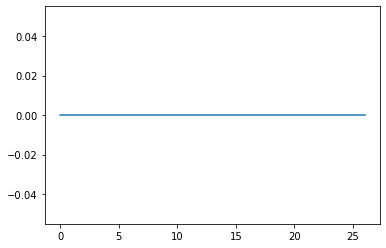

In [14]:
import matplotlib.pyplot as plt
rule_size = rule_size.cpu().detach().numpy()
plt.plot(rule_size[2])

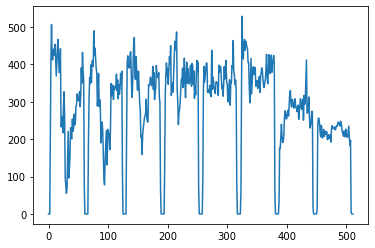

In [15]:
plt.plot(rule_size.sum(axis=1))

In [16]:
tile_rule_size = rule_size.sum(axis=1)

(array([0.00738422, 0.00014768, 0.00014768, 0.        , 0.00059074,
        0.00059074, 0.00044305, 0.00044305, 0.        , 0.00059074,
        0.00014768, 0.00029537, 0.00029537, 0.00088611, 0.00088611,
        0.00310137, 0.00324905, 0.00413516, 0.00251063, 0.0019199 ,
        0.00206758, 0.00251063, 0.00295369, 0.00369211, 0.002806  ,
        0.0047259 , 0.00575969, 0.00428284, 0.00413516, 0.00398748,
        0.00324905, 0.00251063, 0.00147684, 0.00132916, 0.00118147,
        0.00059074, 0.00014768, 0.00014768, 0.00014768, 0.00014768]),
 array([  0.   ,  13.225,  26.45 ,  39.675,  52.9  ,  66.125,  79.35 ,
         92.575, 105.8  , 119.025, 132.25 , 145.475, 158.7  , 171.925,
        185.15 , 198.375, 211.6  , 224.825, 238.05 , 251.275, 264.5  ,
        277.725, 290.95 , 304.175, 317.4  , 330.625, 343.85 , 357.075,
        370.3  , 383.525, 396.75 , 409.975, 423.2  , 436.425, 449.65 ,
        462.875, 476.1  , 489.325, 502.55 , 515.775, 529.   ]),
 <BarContainer object of 40 artists

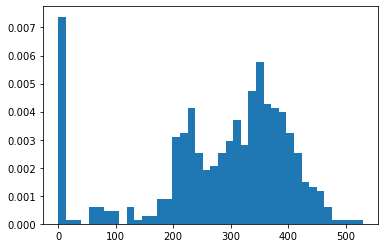

In [17]:
plt.hist(tile_rule_size,40,density=True)

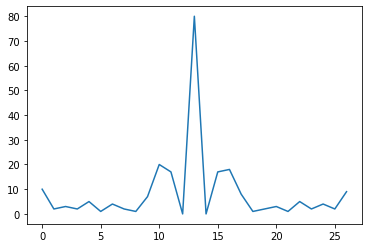

In [24]:
plt.plot(rule_size[100])
